# Evaluación modelos CO y FHMM

Vamos a poner a prueba los modelos de desagregación previamente entrenados en fases anteriores, para los cual deberiamos utilizar un conjunto de datos distinto al usado en el entrenamiento, con tal de aplicar las métricas provistas por NILMTK.

En primer lugar cargamos las ibrerías y realizamos otros ajustes:

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='./data/'

## Set de Validación

Ahora tomamos una franja  horaria para validación  que no ha sido utilizada para entrenamiento  

In [5]:
#Set para validación


valid = DataSet('ualm2.h5')

valid.set_window(start="2023-05-11 16:19:09", end="2023-05-11 17:13:34")

valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6])
print(valid_Devices)

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)


Ahora marcamos con etiquetas a todos los medidores

In [6]:
labels = pd.DataFrame({'Instances': list(range(1,7)),
                       'Meters': ['Main', 'fryer', 'LED Lamp',  'Incandescent lamp','Laptop Computer', 'Fan']})
print ("** Etiquetas ***")

print (labels)

Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]

** Etiquetas ***
   Instances             Meters
0          1               Main
1          2              fryer
2          3           LED Lamp
3          4  Incandescent lamp
4          5    Laptop Computer
5          6                Fan


Asimismo tambien podemos ver el agregado de los diferentes contadores.

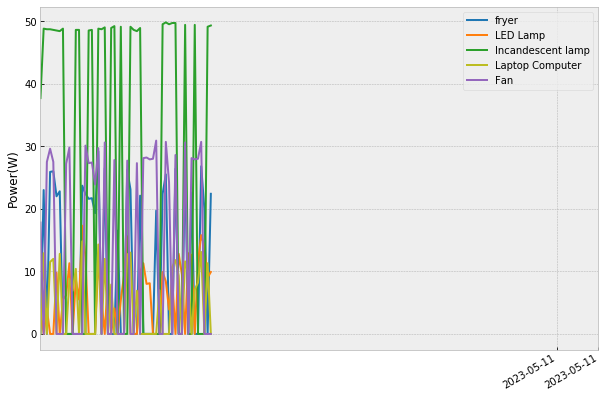

In [7]:
rcParams['figure.figsize'] = (10, 7)

t0='2023-05-11 16:19:09'
t1='2023-05-11 17:00:34'
t2='2023-05-11 17:13:34'


ax2 = valid_Devices.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})[t0:t2].plot()  
#colores
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple']
c=0
for col in colors:    
    ax2.get_lines()[c].set_color(col)
    c=c+1   
ax2.legend(list(Meters.values())[1:6])
ax2.minorticks_off()
ax2.set(xticks=(t1, t2))
#ax2.set_xticklabels(labels=['10-11','11-11'], ha='left', rotation=0)    
ax2.set_ylabel('Power(W)')
plt.savefig('./data/images/5.2_Plot_valid_devices.svg', bbox_inches='tight', transparent=True)
pass

Y ahora vamos a representarlos datos de la validación para el contador principal

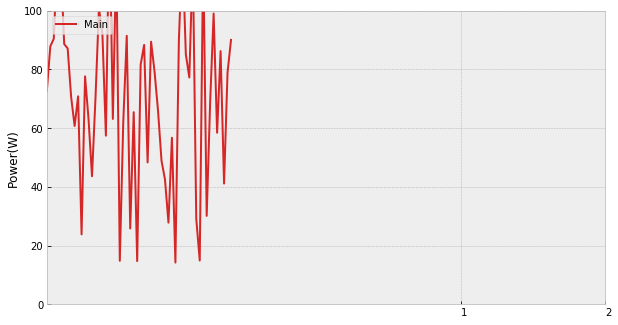

In [8]:
rcParams['figure.figsize'] = (10, 6)

t0='2023-05-11 16:19:09'
t1='2023-05-11 17:00:34'
t2='2023-05-11 17:13:34'

ax1 = next(valid_Main.load(ac_type='active', sample_period=60, resample_kwargs={'how':'first'}))[t0:t2].plot(c='tab:red') 
ax1.legend(['Main'], loc='upper left') #etiquetas
ax1.minorticks_off()
ax1.set(xticks=(t0, t1))
ax1.set_xticklabels(labels=['1','2'], ha='left', rotation=0)    
ax1.set_ylabel('Power(W)')
ax1.set_ylim(0,100)
plt.savefig('./data/images/5.1_Plot_valid_main.svg', bbox_inches='tight', transparent=True)
pass

### Desagregación para validación

La desagregación de los datos de validación se realiza utilizando los datos del MeterGroup valid_Main, el cual contiene el ElecMeter de los datos agregados del sistema eléctrico. Así, el medidor principal  será el dato de entrada para cada uno de los modelos de desagregación entrenados.

Veamos la degregacion  usando difrentes periodos de sampleo , difrentes metodos  y dos de los algoritmos mas tipicos como es el algoritmo combinatorio (CO) y el de las cadenas de Markovv (FHMM)

In [9]:

train = DataSet('ualm2.h5')
train.set_window(start="2023-05-11 14:49:22", end="2023-05-11 16:19:09")



train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[2,3,4,5,6])
train_Devices

from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM

periods = {'1s':1, '10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}
methods = ['mean', 'median','first']  # cambiar abajo tambien

dir_models = './data/NILM/Models/'
times = {} #almacena tiempos de ejecución
null= {} #diccionario nulo
    
for sp_name, sp in periods.items():
    t = []
    
    for method in methods:
        models={'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}

        for model_name, model in models.items():
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)
            #Entrenamiento
            model.MIN_CHUNK_LENGTH = 1
            import time
            start = time.time()
            model.train(train_Devices,
                        num_states_dict={ }, #diccionario de estados nulo, por defecto
                        ac_type='active', #potencia activa, por defecto
                        sample_period=sp, #cambio de muestreo
                        resample_kwargs={'how':'mean'}) #método

            t.append(round(time.time()-start,2)) #tiempo de simulación

                        
            model_dir=data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5'
            output=HDFDataStore(model_dir, 'w')
            print ('Fichero del modelo:',model_dir)
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            
            #fichaje de los tiempos consumidos
            #end = time.time()-start
            #t.append(round(end,2))
            #print ('Tiempos de proceso:',t)
            
    times[sp_name] = t #tiempo de simulación
   
    
#ValueError: Shape of passed values is (4, 8), indices imply (6, 8)    
times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean', 'CO_median', 'FHMM_median','CO_first', 'FHMM_first'])


    
    
print('\n\nDone!')

******************** CO 1s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Done training!
Fichero del modelo: ./data/NILM/Results/CO_1s_mean_pred.h5
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, da

******************** FHMM 10s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_10s_mean_pred.h5
******************** CO 10s median********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', 

Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Done training!
Fichero del modelo: ./data/NILM/Results/CO_30s_median_pred.h5
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])'
Estimating power demand for 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(

Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 3 states
Fichero del modelo: ./data/NILM/Results/FHMM_60s_median_pred.h5
******************** CO 60s first********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Tra

Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Done training!
Fichero del modelo: ./data/NILM/Results/CO_5min_first_pred.h5
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])'
Estimating power demand for 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(

******************** FHMM 10min first********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 1 states
Fichero del modelo: ./data/NILM/Results/FHMM_10min_first_pred.h5
******************** CO 15min mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DS

Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Done training!
Fichero del modelo: ./data/NILM/Results/CO_30min_mean_pred.h5
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])'
Estimating power demand for 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(

In [10]:
times_v.transpose()

,CO_mean,FHMM_mean,CO_median,FHMM_median,CO_first,FHMM_first
1s,6.26,7.78,6.31,7.75,6.46,8.33
10s,5.41,6.17,5.05,5.01,3.98,4.61
30s,3.50,3.96,3.40,3.85,3.39,3.84
60s,4.35,5.62,4.32,5.56,4.32,5.64
5min,5.58,9.15,6.18,9.51,5.60,8.92
10min,5.66,8.87,5.56,8.92,5.60,8.90
15min,5.60,8.97,5.61,9.27,5.74,8.95
30min,5.64,8.95,5.59,8.99,5.56,8.92


### Comparacion de resultados

Utilizaremos dos archivos de resultados (CO y FHMM 60s - first) para visualizar las predicciones hechas por los modelos y contrastarlas con las mediciones reales de dispositivos en cada caso.

In [11]:
Meters

{ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[]): 'Main',
 ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)]): 'fryer',
 ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)]): 'LED Lamp',
 ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)]): 'Incandescent lamp',
 ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)]): 'Laptop Computer',
 ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)]): 'Fan'}

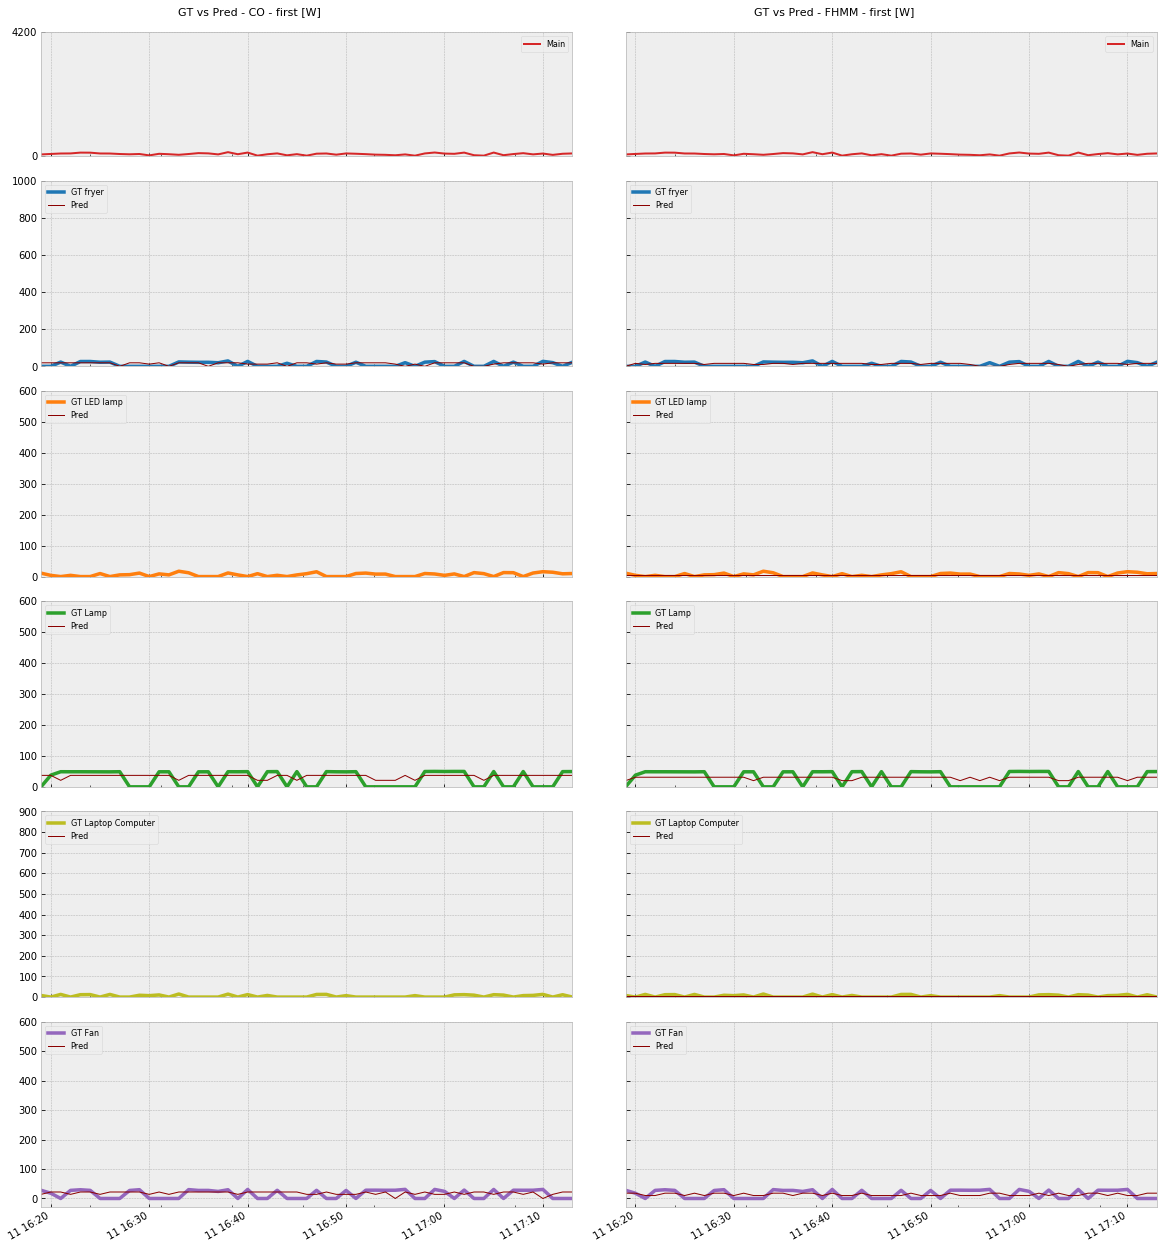

In [12]:
#resultados de predicción modelo CO 60s
CO_60s_first=DataSet(data_dir+'NILM/Results/CO_60s_mean_pred.h5')
elec_CO_60s_first=CO_60s_first.buildings[1].elec
#resultados de predicción modelo FHMM 60s
FHMM_60s_first=DataSet(data_dir+'NILM/Results/FHMM_60s_mean_pred.h5')
elec_FHMM_60s_first= FHMM_60s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_60s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

pred_FHMM=elec_FHMM_60s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),  (ax4,ax10),(ax5,ax11)) = plt.subplots(6, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3]})

t='60s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5],[ax_b,ax7,ax8,ax9,ax10,ax11]]

for i in range(2):
    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['fryer'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['fryer'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT fryer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['LED Lamp'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['LED Lamp'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT LED lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)
    
    gt['Incandescent lamp'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Incandescent lamp'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][3].set_ylim(0,600)
    
    gt['Laptop Computer'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Laptop Computer'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Laptop Computer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Fan'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Fan'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_60s.svg', bbox_inches='tight', transparent=True)
pass

Utilizaremos dos archivos de resultados (CO y FHMM 30s - first) para visualizar las predicciones hechas por los modelos y contrastarlas con las mediciones reales de dispositivos en cada caso.

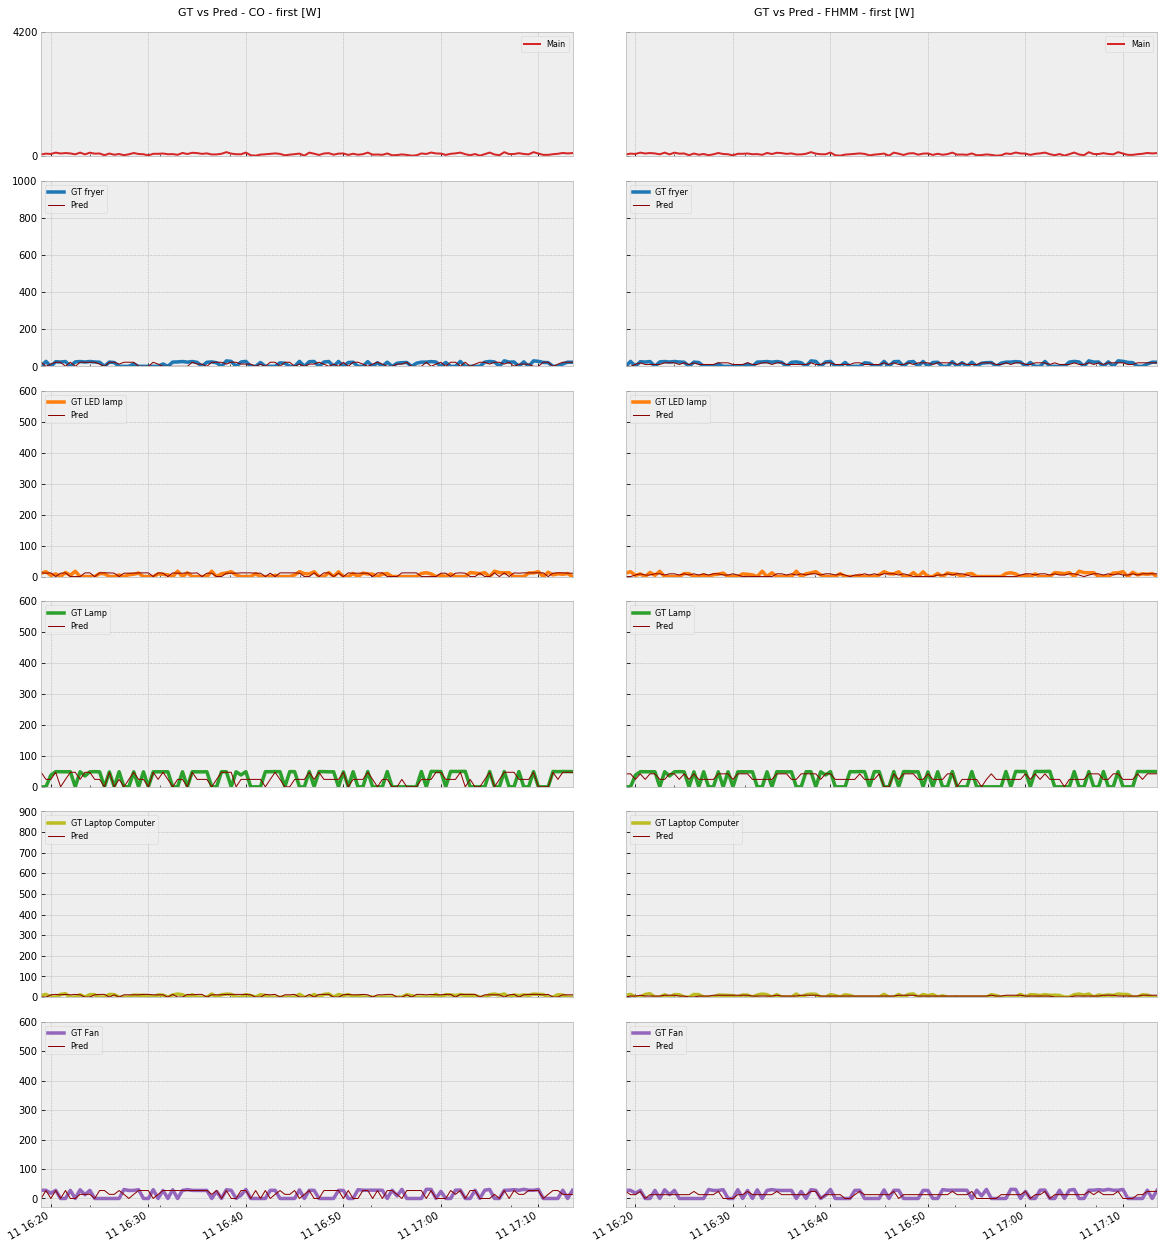

In [13]:
#resultados de predicción modelo CO 30s
CO_30s_first=DataSet(data_dir+'NILM/Results/CO_30s_mean_pred.h5')
elec_CO_30s_first=CO_30s_first.buildings[1].elec
#resultados de predicción modelo FHMM 30s
FHMM_30s_first=DataSet(data_dir+'NILM/Results/FHMM_30s_mean_pred.h5')
elec_FHMM_30s_first= FHMM_30s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=30, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())
pred_CO=elec_CO_30s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

pred_FHMM=elec_FHMM_30s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]
#graficos
rcParams['figure.figsize'] = (20, 24)

fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),  (ax4,ax10),(ax5,ax11)) = plt.subplots(6, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3]})

t='30s'; m1='_CO'; m2='_FHMM'; f=8
pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5],[ax_b,ax7,ax8,ax9,ax10,ax11]]

for i in range(2):

    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['fryer'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['fryer'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT fryer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['LED Lamp'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['LED Lamp'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT LED lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)
    
    gt['Incandescent lamp'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Incandescent lamp'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][3].set_ylim(0,600)
    
    gt['Laptop Computer'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Laptop Computer'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Laptop Computer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Fan'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Fan'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

  
    
      

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_30s.svg', bbox_inches='tight', transparent=True)
pass

Utilizaremos dos archivos de resultados (CO y FHMM 1s - first) para visualizar las predicciones hechas por los modelos y contrastarlas con las mediciones reales de dispositivos en cada caso.

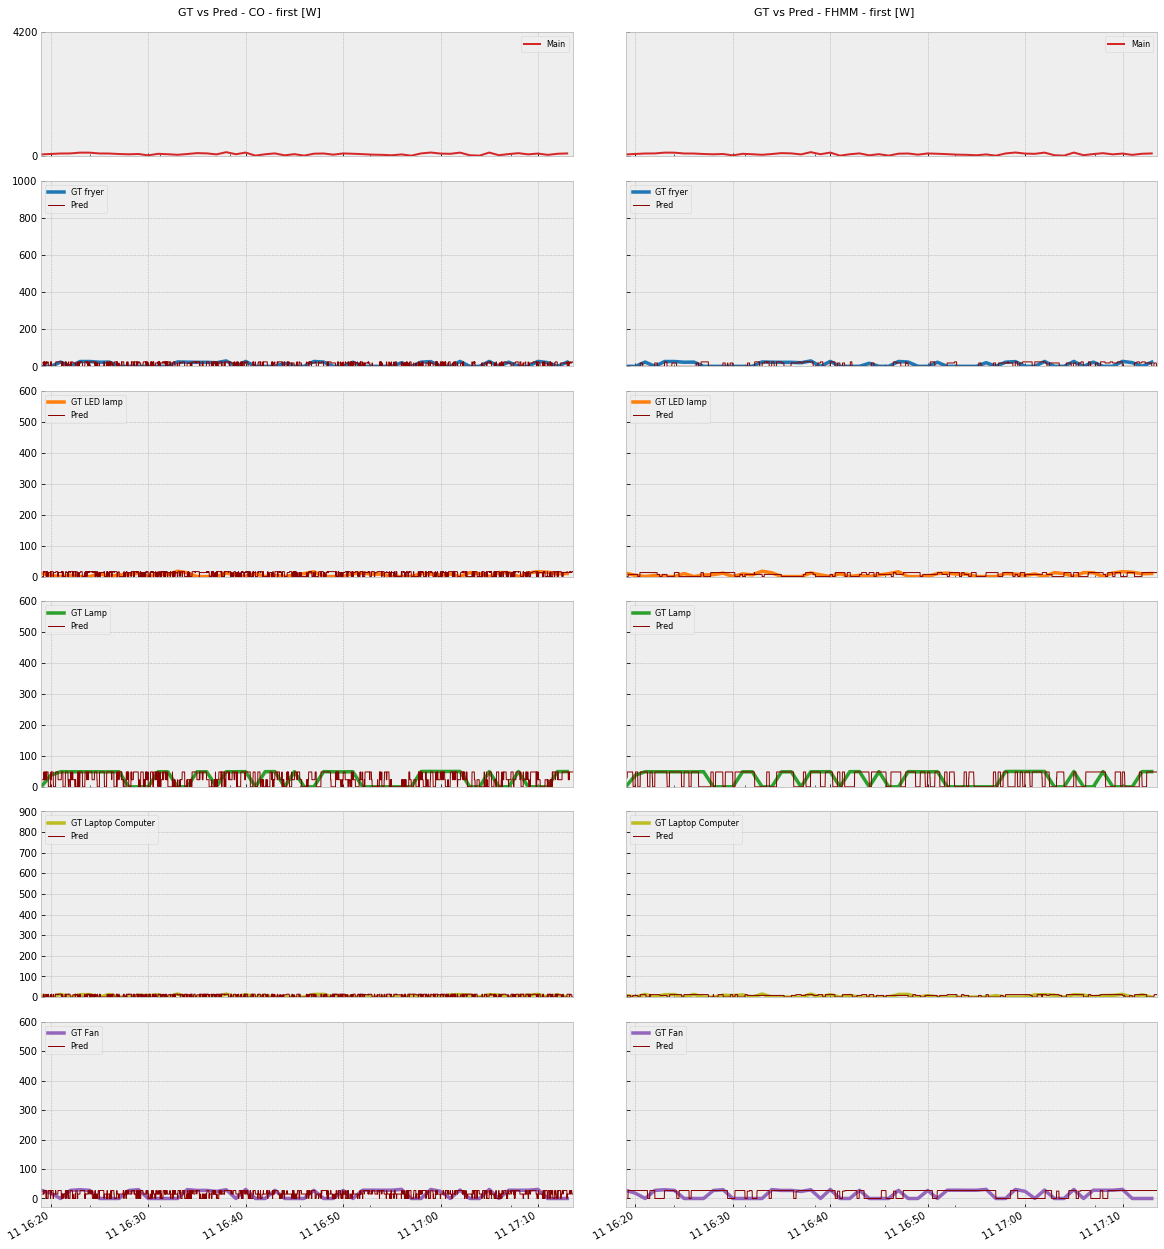

In [14]:
#resultados de predicción modelo CO 1s
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_1s_mean_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec
#resultados de predicción modelo FHMM 1s
FHMM_1s_first=DataSet(data_dir+'NILM/Results/FHMM_1s_mean_pred.h5')
elec_FHMM_1s_first= FHMM_1s_first.buildings[1].elec
#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_1s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]
pred_FHMM=elec_FHMM_1s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),  (ax4,ax10),(ax5,ax11)) = plt.subplots(6, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8
pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5],[ax_b,ax7,ax8,ax9,ax10,ax11]]

for i in range(2):

    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['fryer'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['fryer'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT fryer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['LED Lamp'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['LED Lamp'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT LED lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)
    
    gt['Incandescent lamp'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Incandescent lamp'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][3].set_ylim(0,600)
    
    gt['Laptop Computer'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Laptop Computer'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Laptop Computer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Fan'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Fan'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)
   
      

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_1s.svg', bbox_inches='tight', transparent=True)
pass

## metodo median

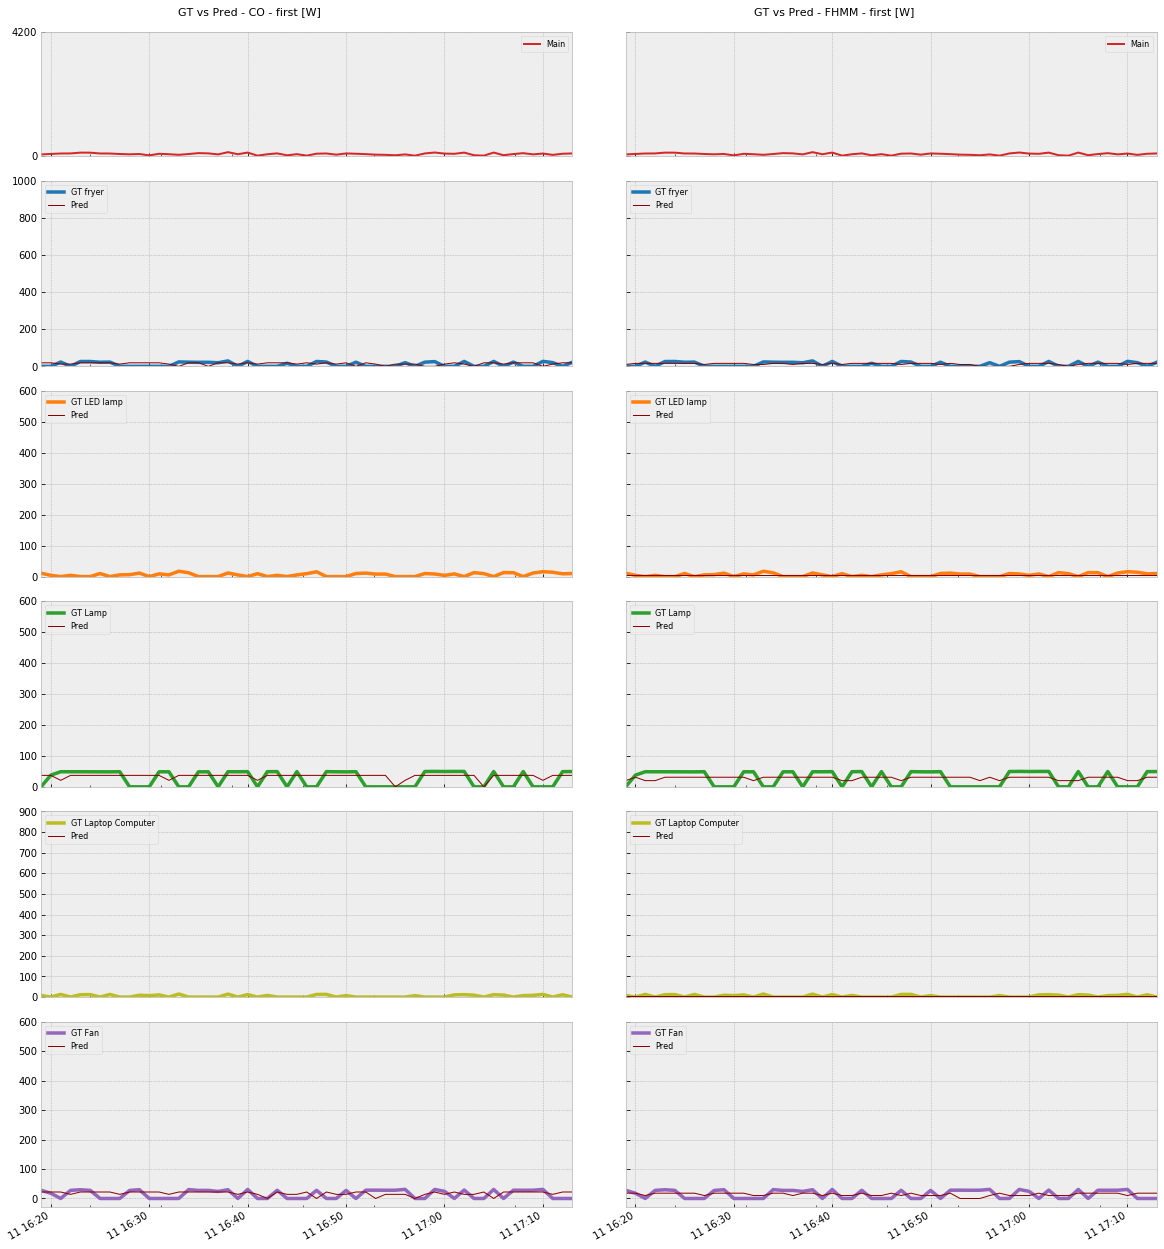

In [15]:
#resultados de predicción modelo CO 60s
CO_60s_first=DataSet(data_dir+'NILM/Results/CO_60s_median_pred.h5')
elec_CO_60s_first=CO_60s_first.buildings[1].elec
#resultados de predicción modelo FHMM 60s
FHMM_60s_first=DataSet(data_dir+'NILM/Results/FHMM_60s_median_pred.h5')
elec_FHMM_60s_first= FHMM_60s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_60s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

pred_FHMM=elec_FHMM_60s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),  (ax4,ax10),(ax5,ax11)) = plt.subplots(6, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3]})

t='60s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5],[ax_b,ax7,ax8,ax9,ax10,ax11]]

for i in range(2):

    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['fryer'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['fryer'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT fryer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['LED Lamp'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['LED Lamp'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT LED lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)
    
    gt['Incandescent lamp'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Incandescent lamp'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][3].set_ylim(0,600)
    
    gt['Laptop Computer'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Laptop Computer'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Laptop Computer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Fan'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Fan'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

  

    
for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_60s.svg', bbox_inches='tight', transparent=True)
pass

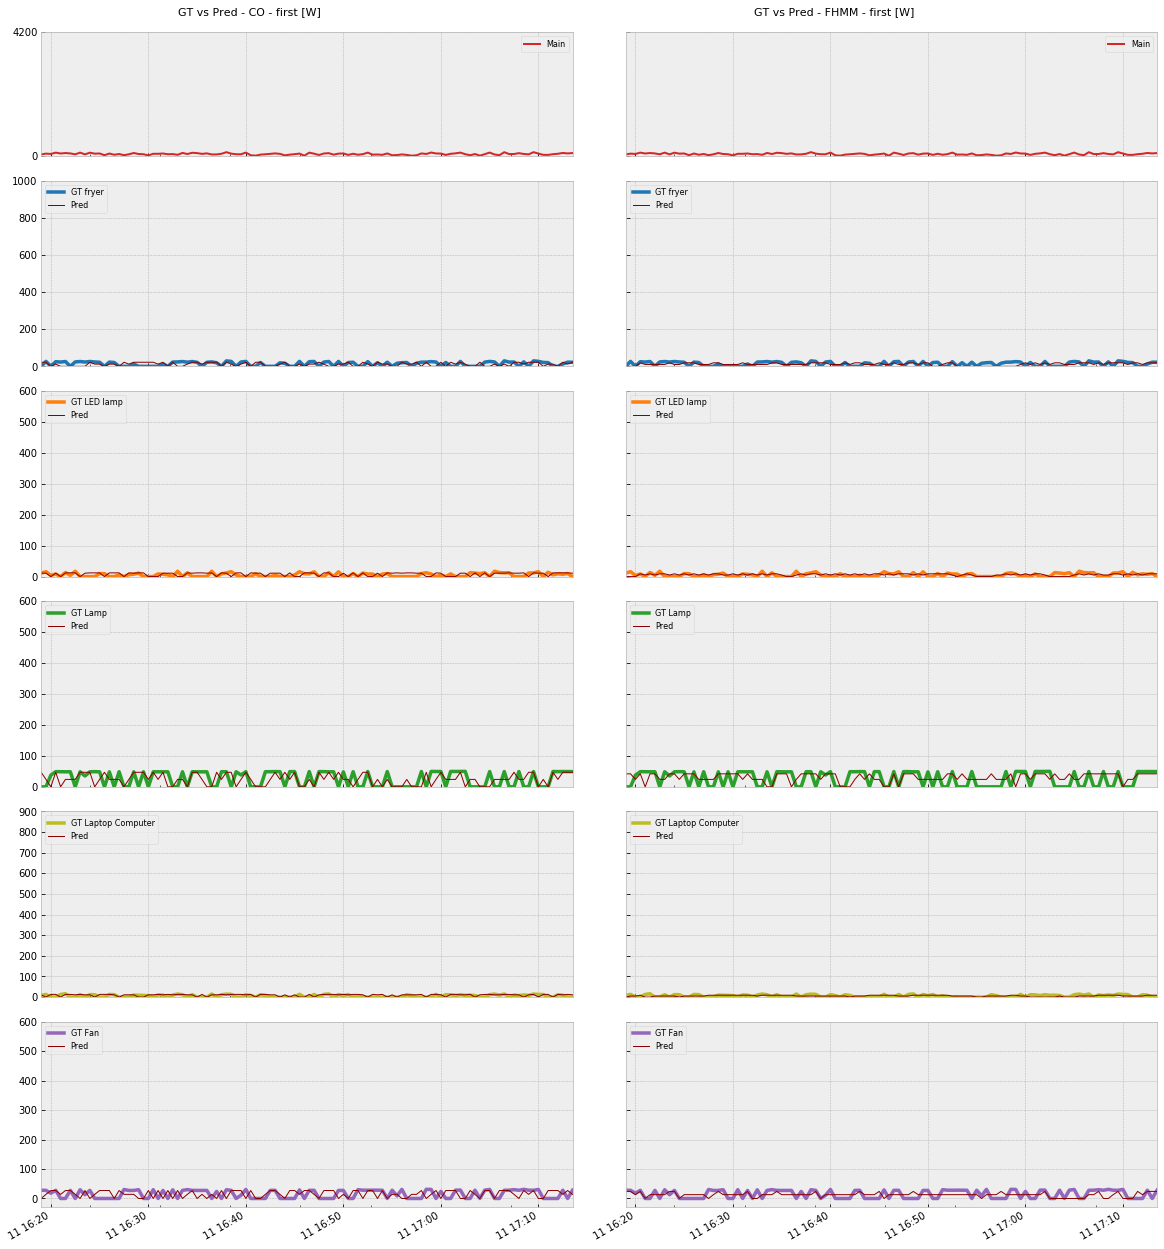

In [16]:
#resultados de predicción modelo CO 30s
CO_30s_first=DataSet(data_dir+'NILM/Results/CO_30s_median_pred.h5')
elec_CO_30s_first=CO_30s_first.buildings[1].elec
#resultados de predicción modelo FHMM 30s
FHMM_30s_first=DataSet(data_dir+'NILM/Results/FHMM_30s_median_pred.h5')
elec_FHMM_30s_first= FHMM_30s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=30, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())
pred_CO=elec_CO_30s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

pred_FHMM=elec_FHMM_30s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]
#graficos
rcParams['figure.figsize'] = (20, 24)

fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),  (ax4,ax10),(ax5,ax11)) = plt.subplots(6, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3]})

t='30s'; m1='_CO'; m2='_FHMM'; f=8
pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5],[ax_b,ax7,ax8,ax9,ax10,ax11]]

for i in range(2):

    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['fryer'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['fryer'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT fryer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['LED Lamp'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['LED Lamp'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT LED lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)
    
    gt['Incandescent lamp'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Incandescent lamp'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][3].set_ylim(0,600)
    
    gt['Laptop Computer'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Laptop Computer'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Laptop Computer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Fan'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Fan'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

  
     

    
for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_30s.svg', bbox_inches='tight', transparent=True)
pass

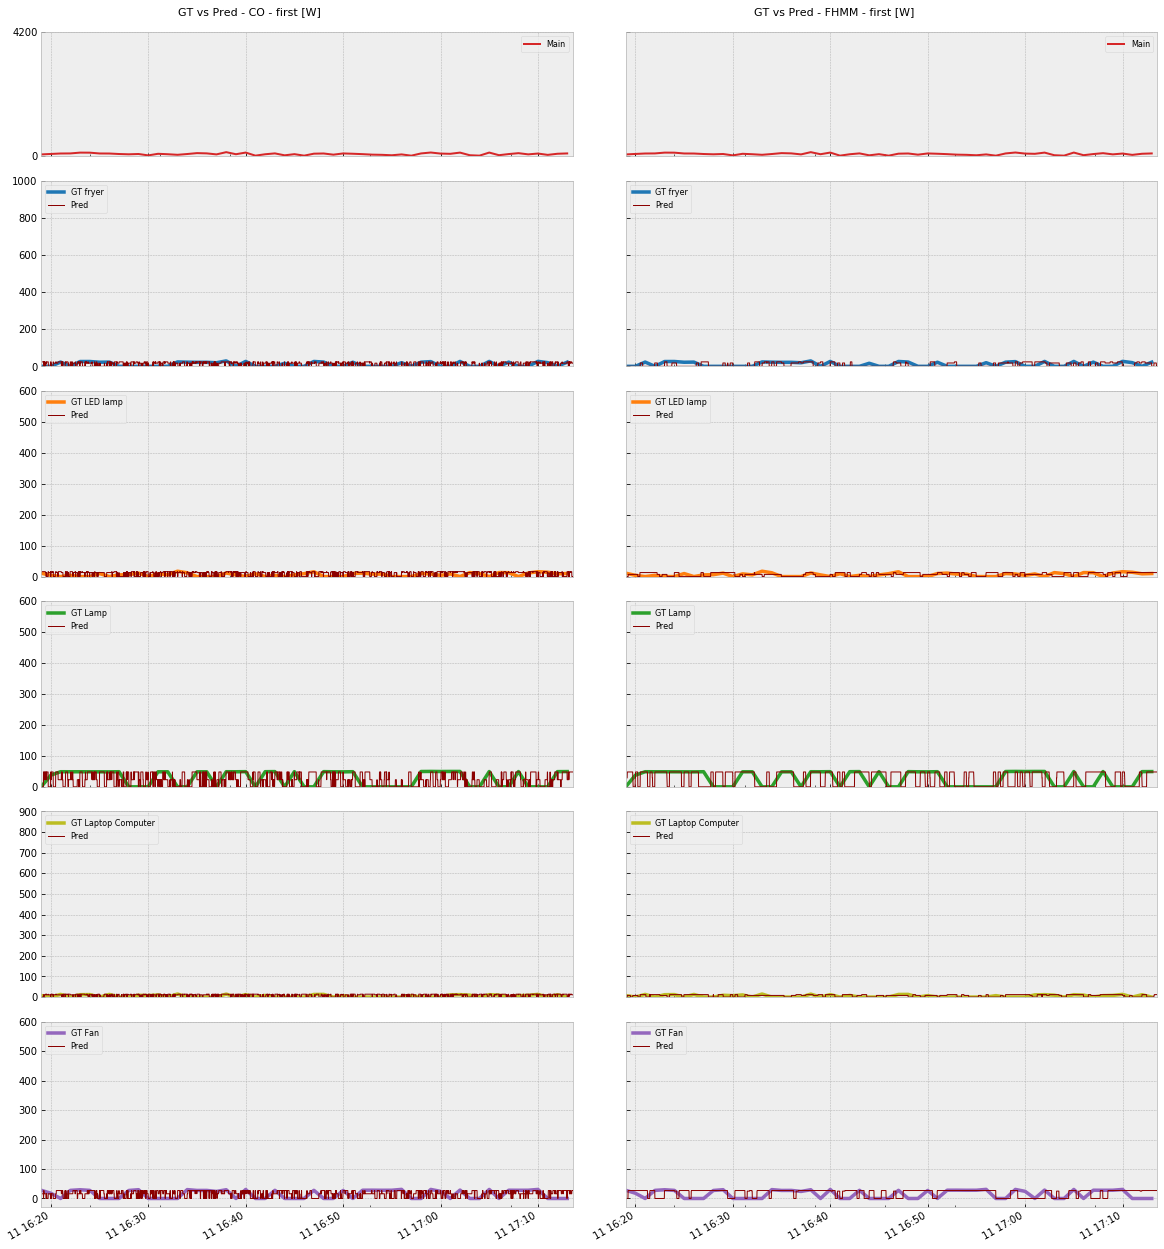

In [17]:
#resultados de predicción modelo CO 1s
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_1s_median_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec
#resultados de predicción modelo FHMM 1s
FHMM_1s_first=DataSet(data_dir+'NILM/Results/FHMM_1s_median_pred.h5')
elec_FHMM_1s_first= FHMM_1s_first.buildings[1].elec
#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_1s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]
pred_FHMM=elec_FHMM_1s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),  (ax4,ax10),(ax5,ax11)) = plt.subplots(6, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8
pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5],[ax_b,ax7,ax8,ax9,ax10,ax11]]

for i in range(2):

    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['fryer'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['fryer'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT fryer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['LED Lamp'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['LED Lamp'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT LED lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)
    
    gt['Incandescent lamp'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Incandescent lamp'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][3].set_ylim(0,600)
    
    gt['Laptop Computer'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Laptop Computer'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Laptop Computer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Fan'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Fan'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

  
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_1s.svg', bbox_inches='tight', transparent=True)
pass

## metodo first

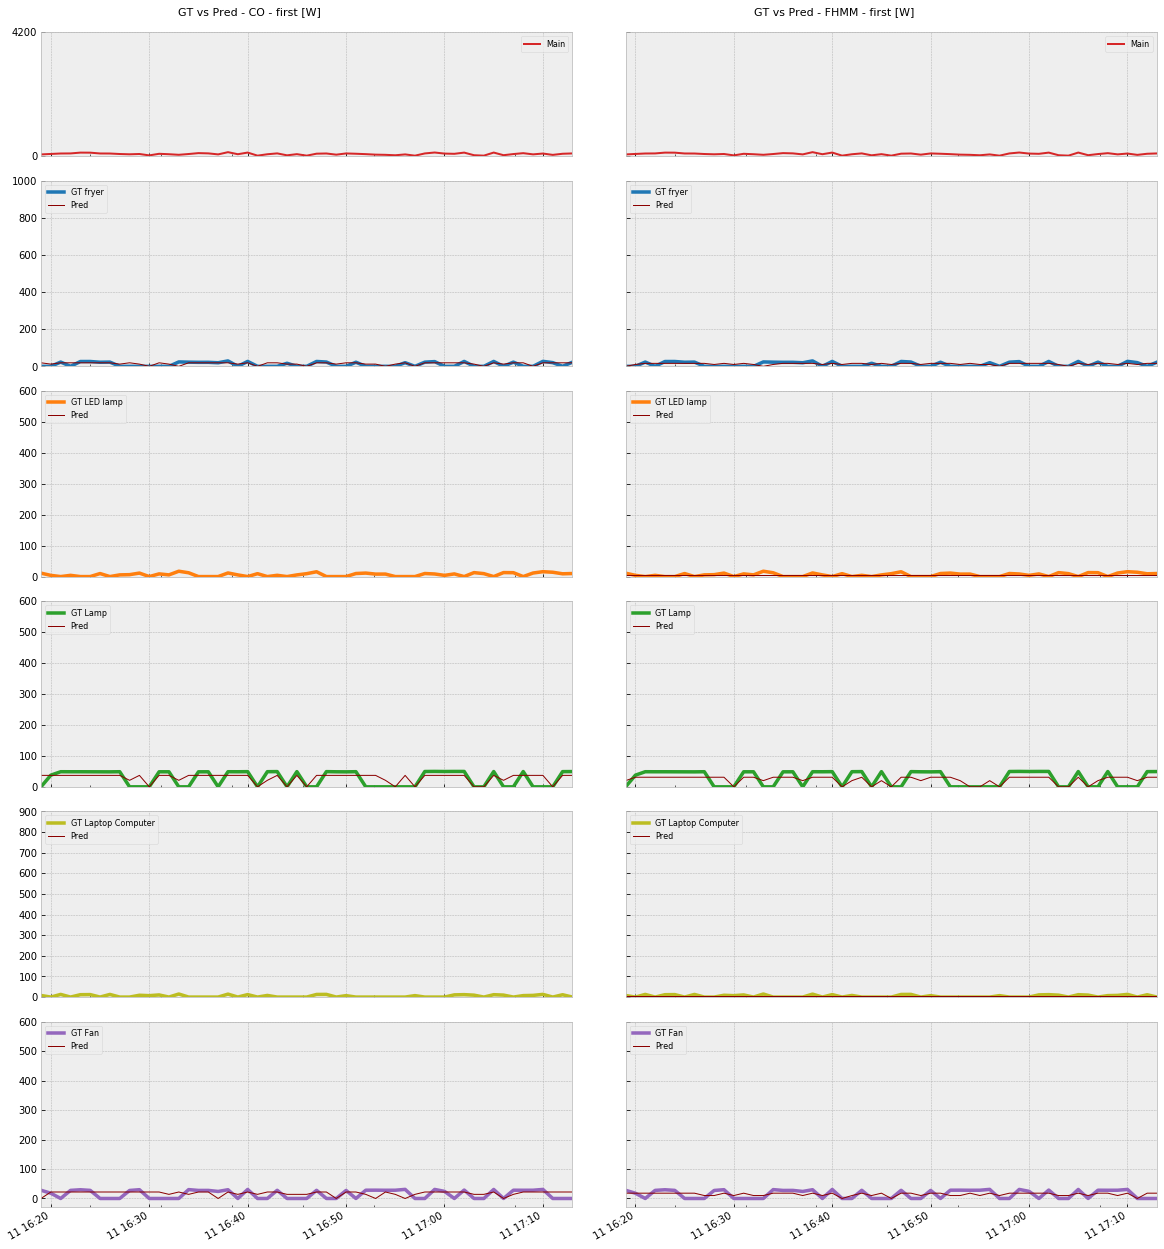

In [18]:
#resultados de predicción modelo CO 60s
CO_60s_first=DataSet(data_dir+'NILM/Results/CO_60s_first_pred.h5')
elec_CO_60s_first=CO_60s_first.buildings[1].elec
#resultados de predicción modelo FHMM 60s
FHMM_60s_first=DataSet(data_dir+'NILM/Results/FHMM_60s_first_pred.h5')
elec_FHMM_60s_first= FHMM_60s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_60s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

pred_FHMM=elec_FHMM_60s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),  (ax4,ax10),(ax5,ax11)) = plt.subplots(6, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3]})

t='60s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5],[ax_b,ax7,ax8,ax9,ax10,ax11]]

for i in range(2):

    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['fryer'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['fryer'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT fryer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['LED Lamp'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['LED Lamp'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT LED lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)
    
    gt['Incandescent lamp'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Incandescent lamp'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][3].set_ylim(0,600)
    
    gt['Laptop Computer'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Laptop Computer'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Laptop Computer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Fan'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Fan'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)
    
      
   # ax[i][5].set_xticklabels(labels=['14-Febr','14:00','14:30','14:45','15:00','15:30','16:00','16:30','17:00'])         
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_60s.svg', bbox_inches='tight', transparent=True)
pass

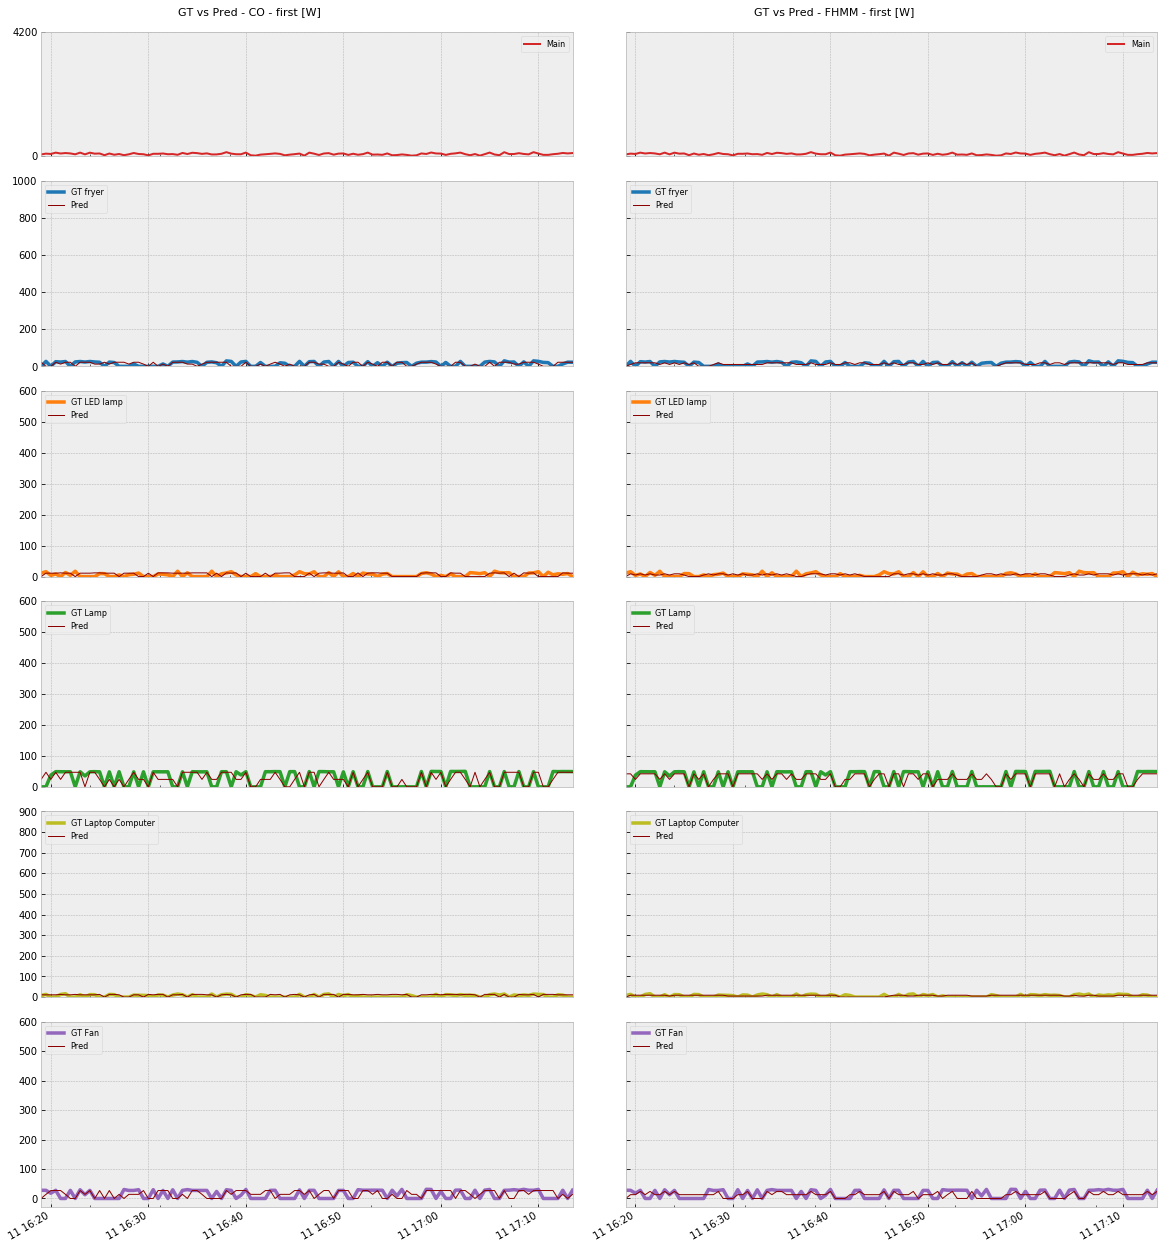

In [19]:
#resultados de predicción modelo CO 30s
CO_30s_first=DataSet(data_dir+'NILM/Results/CO_30s_first_pred.h5')
elec_CO_30s_first=CO_30s_first.buildings[1].elec
#resultados de predicción modelo FHMM 30s
FHMM_30s_first=DataSet(data_dir+'NILM/Results/FHMM_30s_first_pred.h5')
elec_FHMM_30s_first= FHMM_30s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=30, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())
pred_CO=elec_CO_30s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

pred_FHMM=elec_FHMM_30s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]
#graficos
rcParams['figure.figsize'] = (20, 24)

fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),  (ax4,ax10),(ax5,ax11)) = plt.subplots(6, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3]})

t='30s'; m1='_CO'; m2='_FHMM'; f=8
pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5],[ax_b,ax7,ax8,ax9,ax10,ax11]]

for i in range(2):

    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['fryer'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['fryer'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT fryer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['LED Lamp'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['LED Lamp'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT LED lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)
    
    gt['Incandescent lamp'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Incandescent lamp'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][3].set_ylim(0,600)
    
    gt['Laptop Computer'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Laptop Computer'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Laptop Computer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Fan'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Fan'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)
    
    
    
for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_30s.svg', bbox_inches='tight', transparent=True)
pass

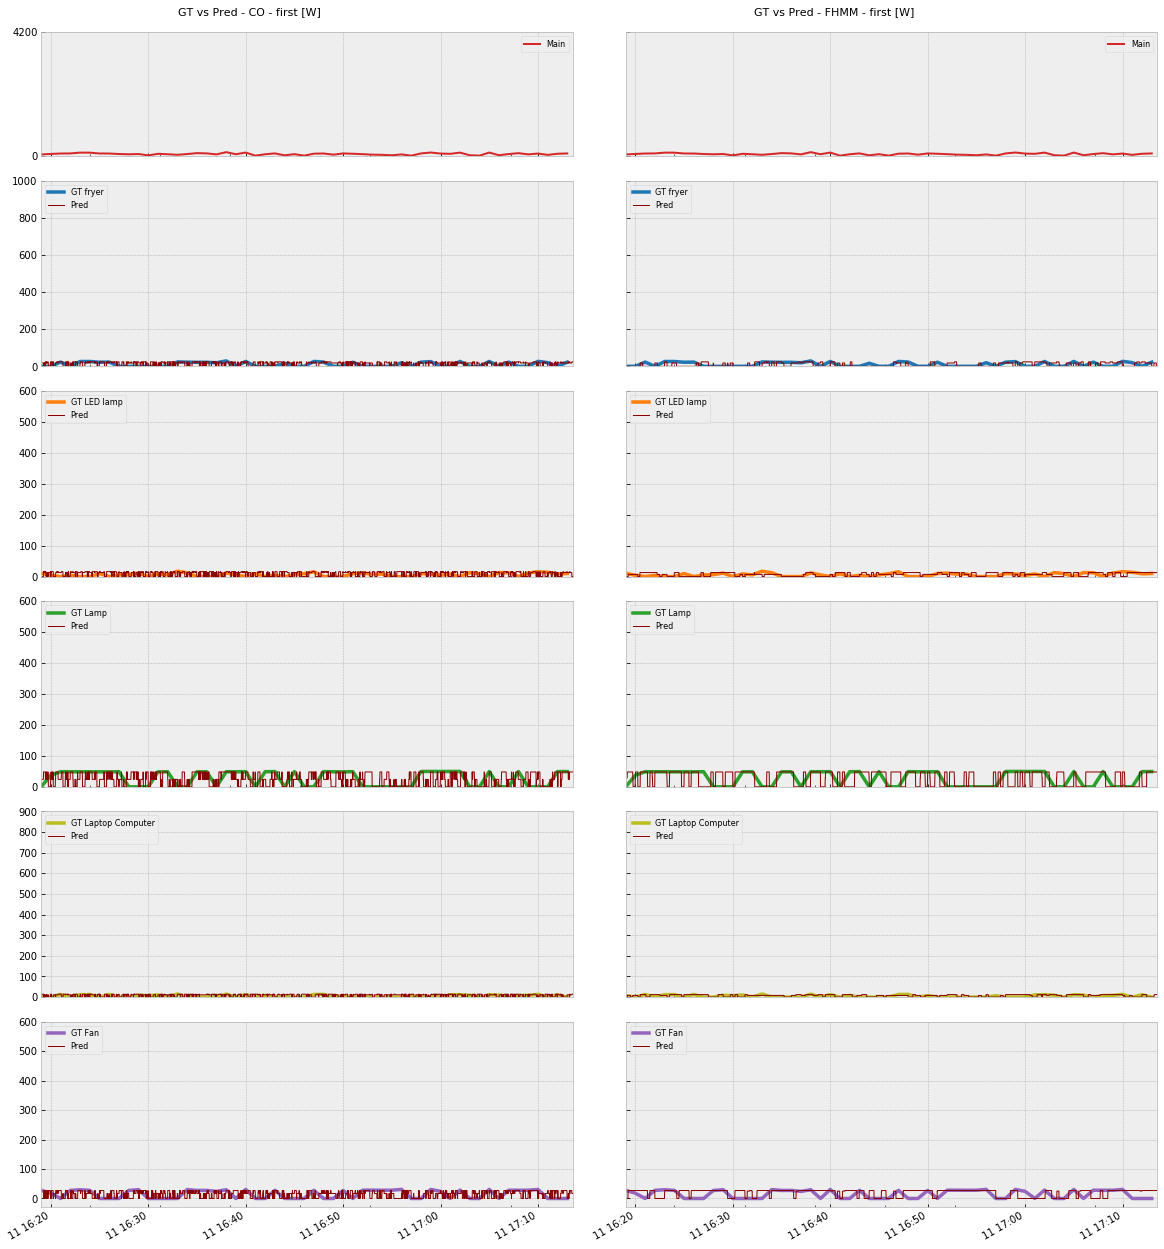

In [20]:
#resultados de predicción modelo CO 1s
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_1s_first_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec
#resultados de predicción modelo FHMM 1s
FHMM_1s_first=DataSet(data_dir+'NILM/Results/FHMM_1s_first_pred.h5')
elec_FHMM_1s_first= FHMM_1s_first.buildings[1].elec
#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_1s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]
pred_FHMM=elec_FHMM_1s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),  (ax4,ax10),(ax5,ax11)) = plt.subplots(6, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8
pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5],[ax_b,ax7,ax8,ax9,ax10,ax11]]

for i in range(2):

    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['fryer'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['fryer'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT fryer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['LED Lamp'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['LED Lamp'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT LED lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)
    
    gt['Incandescent lamp'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Incandescent lamp'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][3].set_ylim(0,600)
    
    gt['Laptop Computer'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Laptop Computer'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Laptop Computer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Fan'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Fan'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)
    
    
      

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_1s.svg', bbox_inches='tight', transparent=True)
pass